# Group 1
Fabio Ceruti - Fabio Martino - Alex Lucchini - Jacopo Biggiogera

This notebook contains the code that we used to carry out to apply transfer learning for predicting the species by using the only the bounding box content. Additionally, we also extract the heatmaps for each prediction on test.

In [1]:
import pandas as pd 
import numpy as np 
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from collections import defaultdict
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.image import resize_with_pad, ResizeMethod
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from random import shuffle
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tqdm import tqdm
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.callbacks import CSVLogger, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

## Defining the model through transfer learning

In [11]:
#Import the model from keras.applications, there are plenty of models. I have chosen the one with the best performance
base_model = ResNet50(weights='imagenet',input_shape=(239, 225, 3),include_top=False)  # original input shape for model (480,480,3)
base_model.trainable = True #freeze parameters of imported model

inputs = keras.Input(shape=(239, 225, 3))
x = base_model(inputs, training=True)
x = keras.layers.Conv2D(64, (3, 3), activation='relu',name='last_conv')(x)
x = keras.layers.GlobalAveragePooling2D()(x)
outputs = keras.layers.Dense(12, activation='softmax')(x) #predict the class
model = keras.Model(inputs, outputs) #put everything together
model.summary()

Model: "model_516"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 239, 225, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 last_conv (Conv2D)          (None, 6, 6, 64)          1179712   
                                                                 
 global_average_pooling2d (G  (None, 64)               0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 12)                780       
                                                                 
Total params: 24,768,204
Trainable params: 24,715,084
Non-trainable params: 53,120
________________________________________

## Preparing the data for the analysis
This section prepares the data for the analysis by loading it and creating train and validation data with balanced classes.

In [13]:
animals = pd.read_csv('12paths_df.csv')
animals.head()

paths = set()
for i in os.listdir('Animals_bbcontent'):
    for pic in os.listdir('Animals_bbcontent/' + i):
        paths.add(i + '/' + pic)
        
path_full = {i[8:] for i in animals['path']}

label_mapping = {'Anolis carolinensis': '0', 'Canis latrans':'1','Chelydra serpentina':'2', 'Harmonia axyridis':'3',
'Junonia coenia':'4', 'Pachydiplax longipennis':'5', 'Pandion haliaetus':'6', 'Picoides pubescens':'7',
'Procyon lotor':'8', 'Sciurus carolinensis':'8','Sciurus carolinensis':'9', 'Spinus tristis':'10', 'Trachemys scripta elegans':'11'}

paths_diff = paths - path_full

labels = [label_mapping[i.split('/')[0]] for i in paths_diff]

extra_bb = pd.DataFrame()
extra_bb['path'] = list(paths_diff)
extra_bb['label'] = labels

for i in range(len(extra_bb['path'])):
    extra_bb.loc[i, 'path'] = 'Animals_bbcontent/' + extra_bb.loc[i, 'path']

extra_bb.head()

,path,label
0,Animals_bbcontent/Procyon lotor/dc7d1f09792115...,8
1,Animals_bbcontent/Spinus tristis/b4c5a2c59d9b3...,10
2,Animals_bbcontent/Procyon lotor/9f45e3eef12e5c...,8
3,Animals_bbcontent/Canis latrans/111fdee26c0080...,1
4,Animals_bbcontent/Spinus tristis/2f0d24fdb44cc...,10


In [14]:
#Creating a balanced split between training and test
paths=pd.read_csv('train_val_data.csv')
paths['label']=paths['label'].astype('str')
paths['bbcontent_path'] = ['Animals_bbcontent'+ i[7:] for i in paths['path']]
X_train, X_val, y_train, y_val = train_test_split(paths['bbcontent_path'],paths['label'], test_size=0.176, stratify=paths['label'])
train_df = pd.DataFrame({'path':X_train, 'label':y_train}).reset_index(drop=True)
train_df = pd.concat([train_df, extra_bb])
valid_df = pd.DataFrame({'path':X_val, 'label':y_val}).reset_index(drop=True)
valid_df['full_pic_path'] = ['Animals'+ i[17:] for i in valid_df['path']]
valid_df.head()

,path,label,full_pic_path
0,Animals_bbcontent/Spinus tristis/41bbc24e0c12b...,10,Animals/Spinus tristis/41bbc24e0c12b8d1a802188...
1,Animals_bbcontent/Pachydiplax longipennis/1192...,5,Animals/Pachydiplax longipennis/1192df0bee858c...
2,Animals_bbcontent/Junonia coenia/6ebc4b351400d...,4,Animals/Junonia coenia/6ebc4b351400d3f5fefe586...
3,Animals_bbcontent/Pachydiplax longipennis/87cd...,5,Animals/Pachydiplax longipennis/87cd71a7be71ca...
4,Animals_bbcontent/Pachydiplax longipennis/1997...,5,Animals/Pachydiplax longipennis/19978f587a5759...


In [16]:
# Setting up the generators.
#NOTE: we have two generators like we do in all our model since often pcitures for the train and validation are
# taken from two dataframes which might have different piture paths (ex. train pictures come from a folder with
#masked pictures whole validation comes form a folder with complete pictures)

def togpu(img):
    with tf.device('/gpu:0'):
        tens_data = tf.constant(img)
    return tens_data

train_datagen=ImageDataGenerator(rescale=1./255,preprocessing_function = togpu, #check that you can make multiple functions and pass them in a list
                                 rotation_range=90, brightness_range=[0.1, 2], shear_range=90, zoom_range=[1, 2])

val_datagen=ImageDataGenerator(rescale=1./255,preprocessing_function = togpu)

batch_s = 20


train_generator=train_datagen.flow_from_dataframe(
    train_df, 
    x_col = 'path',
    y_col = 'label',
    class_mode = 'categorical',
    target_size=(239, 225),
    batch_size=batch_s
)

validation_generator=val_datagen.flow_from_dataframe(
   valid_df, 
    x_col = 'full_pic_path',
    y_col = 'label',
    class_mode = 'categorical',
    target_size=(239, 225),
    batch_size=batch_s,
    shuffle=False
)

Found 13608 validated image filenames belonging to 12 classes.
Found 2557 validated image filenames belonging to 12 classes.


/anaconda/envs/py38_default/lib/python3.8/site-packages/keras/preprocessing/image.py:1137: UserWarning: Found 1 invalid image filename(s) in x_col="path". These filename(s) will be ignored.
  warnings.warn(


### Compiling the model and fitting it

In [10]:
model.compile(optimizer = 'rmsprop',
              loss = 'categorical_crossentropy',
              metrics = ['accuracy']) 

In [11]:
earlystop = EarlyStopping(monitor='val_accuracy',
                        min_delta=0.01,
                        patience=3,
                        verbose=1,
                        mode='auto')

csv_logger=CSVLogger('model_logs/training_bbcontent_transfer.log',separator=",",append=False)

In [12]:
stepepoch = 13608/batch_s
valsteps = 2557/batch_s
history=model.fit(train_generator,
          steps_per_epoch=stepepoch, # this is for the training images

          epochs=10, 

          validation_data=validation_generator,
          validation_steps=valsteps,
        callbacks=[earlystop, csv_logger])

Epoch 1/10
680/680 [==============================] - 659s 924ms/step - loss: 2.2382 - accuracy: 0.2429 - val_loss: 2.0057 - val_accuracy: 0.3152
Epoch 2/10
680/680 [==============================] - 624s 917ms/step - loss: 1.7883 - accuracy: 0.3973 - val_loss: 1.8641 - val_accuracy: 0.4048
Epoch 3/10
680/680 [==============================] - 623s 916ms/step - loss: 1.6004 - accuracy: 0.4669 - val_loss: 1.8051 - val_accuracy: 0.4482
Epoch 4/10
680/680 [==============================] - 624s 917ms/step - loss: 1.4903 - accuracy: 0.5010 - val_loss: 1.6433 - val_accuracy: 0.4619
Epoch 5/10
680/680 [==============================] - 622s 915ms/step - loss: 1.4170 - accuracy: 0.5265 - val_loss: 1.5701 - val_accuracy: 0.4838
Epoch 6/10
680/680 [==============================] - 623s 916ms/step - loss: 1.3626 - accuracy: 0.5470 - val_loss: 1.6270 - val_accuracy: 0.4877
Epoch 7/10
680/680 [==============================] - 623s 915ms/step - loss: 1.3147 - accuracy: 0.5638 - val_loss: 1.6218 -

### Saving results on Validation set and saving the models

In [13]:
prediction_classes = np.array([])
true_classes =  np.array([])
step = 0
for x, y in tqdm(validation_generator):
    prediction_classes = np.concatenate([prediction_classes,
                       np.argmax(model.predict(x, verbose=0), axis = -1)])
    true_classes = np.concatenate([true_classes, np.argmax(y, axis=-1)])
    step+=1
    if step == 128:
        break

 99%|█████████▉| 127/128 [01:05<00:00,  1.95it/s]


In [14]:
valid_df['predicted_label_vanilla_transfer']=prediction_classes[:2557]
valid_df.to_csv('val_results/transfer_bbcontent_resultsval.csv', index=False)

In [15]:
model.save('saved_models/model_bbcontent_transfer')
model.save('saved_models/model_bbcontent_transfer', save_format = 'H5')

INFO:tensorflow:Assets written to: saved_models/model_bbcontent_transfer/assets


INFO:tensorflow:Assets written to: saved_models/model_bbcontent_transfer/assets


INFO:tensorflow:Assets written to: saved_models/model_bbcontent_transfer/assets


INFO:tensorflow:Assets written to: saved_models/model_bbcontent_transfer/assets


### Running model on test set and saving results

In [50]:
#loading model
loaded_model = tf.keras.models.load_model('saved_models/model_bbcontent_transfer')
loaded_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 239, 225, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 last_conv (Conv2D)          (None, 6, 6, 64)          1179712   
                                                                 
 global_average_pooling2d (G  (None, 64)               0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 12)                780       
                                                                 
Total params: 24,768,204
Trainable params: 24,715,084
Non-trainable params: 53,120
____________________________________________

In [51]:
test_df = pd.read_csv('test_data.csv')
test_df['label']=test_df['label'].astype('str')
test_df.head()

,path,label
0,Animals/Pandion haliaetus/fdd144a72e5da77cff15...,6
1,Animals/Spinus tristis/e9c56231718b9b11758f5f9...,10
2,Animals/Pachydiplax longipennis/c67ae3e186acb3...,5
3,Animals/Canis latrans/0a922be91bac509ef2bc0a44...,1
4,Animals/Trachemys scripta elegans/fa1dd0961941...,11


In [76]:
from keras.preprocessing.image import ImageDataGenerator

test_datagen=ImageDataGenerator(rescale=1./255,preprocessing_function = togpu)
batch_s = 20

test_generator=test_datagen.flow_from_dataframe(
   test_df, 
    x_col = 'path',
    y_col = 'label',
    class_mode = 'categorical',
    #color_mode='grayscale',#for black and white use: 'grayscale'
    target_size=(239, 225),
    batch_size=batch_s,
    shuffle=False
)


Found 2564 validated image filenames belonging to 12 classes.


In [64]:
loaded_model.evaluate(test_generator)

65/65 [==============================] - 53s 802ms/step - loss: 1.4937 - accuracy: 0.5172


[1.4937268495559692, 0.5171607136726379]

### Generating heatmaps

In [57]:
def get_img_array(img_path, size):
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    
    return heatmap.numpy()

In [77]:
#Saving heatmaps and predicted labels
prediction_classes_test = np.array([])
true_classes_test =  np.array([])
heatmaps = []

img_size = (239, 225)
last_conv_layer_name = "last_conv"
step = 0
for x, y in tqdm(test_generator):
    prediction_classes_test = np.concatenate([prediction_classes_test,
                       np.argmax(loaded_model.predict(x, verbose=0), axis = -1)])
    true_classes_test = np.concatenate([true_classes_test, np.argmax(y, axis=-1)])
    for ar in x:
        heatmap = make_gradcam_heatmap(np.expand_dims(ar, axis=0), loaded_model,last_conv_layer_name )
        heatmaps.append(heatmap)
    step+=1
    if step == 129:
        break

 99%|█████████▉| 128/129 [09:00<00:04,  4.23s/it]


In [78]:
inverse_label_enc = {v:k for k,v in test_generator.class_indices.items()}
t = [inverse_label_enc[i] for i in prediction_classes_test]
test_df['predicted_label'] = t
test_df['heatmap'] = heatmaps

In [81]:
from sklearn.metrics import classification_report
print(classification_report(test_df['label'],test_df['predicted_label'] ))

              precision    recall  f1-score   support

           0       0.45      0.55      0.49       193
           1       0.25      0.32      0.28       199
          10       0.54      0.46      0.50       199
          11       0.34      0.51      0.41       206
           2       0.21      0.23      0.22       146
           3       0.70      0.75      0.72       194
           4       0.81      0.72      0.76       216
           5       0.60      0.87      0.71       239
           6       0.77      0.64      0.70       274
           7       0.59      0.39      0.47       228
           8       0.47      0.40      0.43       222
           9       0.48      0.26      0.34       248

    accuracy                           0.52      2564
   macro avg       0.52      0.51      0.50      2564
weighted avg       0.53      0.52      0.51      2564



In [82]:
test_df.head()

,path,label,predicted_label,heatmap
0,Animals/Pandion haliaetus/fdd144a72e5da77cff15...,6,6,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.21096286, ..."
1,Animals/Spinus tristis/e9c56231718b9b11758f5f9...,10,10,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0...."
2,Animals/Pachydiplax longipennis/c67ae3e186acb3...,5,5,"[[0.13527793, 0.024011567, 0.074567, 0.2230256..."
3,Animals/Canis latrans/0a922be91bac509ef2bc0a44...,1,8,"[[0.22132397, 0.014507692, 0.067461096, 0.0, 0..."
4,Animals/Trachemys scripta elegans/fa1dd0961941...,11,10,"[[0.020542832, 0.27724352, 0.0937886, 0.0, 0.0..."


In [2]:
import pickle
with open('test_results/transfer_bbcontent_testresults.pickle', 'wb') as file:
    pickle.dump(test_df, file)

In [6]:
with open('test_results/transfer_bbcontent_testresults.pickle', "rb") as f:
    state = pickle.load(f)

In [88]:
state.head()

,path,label,predicted_label,heatmap
0,Animals/Pandion haliaetus/fdd144a72e5da77cff15...,6,6,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.21096286, ..."
1,Animals/Spinus tristis/e9c56231718b9b11758f5f9...,10,10,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0...."
2,Animals/Pachydiplax longipennis/c67ae3e186acb3...,5,5,"[[0.13527793, 0.024011567, 0.074567, 0.2230256..."
3,Animals/Canis latrans/0a922be91bac509ef2bc0a44...,1,8,"[[0.22132397, 0.014507692, 0.067461096, 0.0, 0..."
4,Animals/Trachemys scripta elegans/fa1dd0961941...,11,10,"[[0.020542832, 0.27724352, 0.0937886, 0.0, 0.0..."


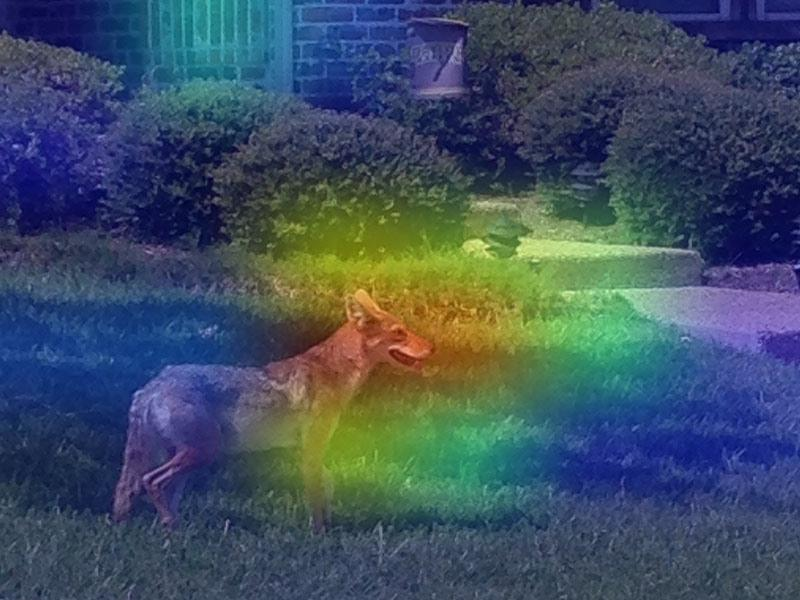

In [97]:
import matplotlib.cm as cm
from IPython.display import Image, display
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.8):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))


save_and_display_gradcam(state['path'][5],state['heatmap'][5])